In [127]:
import torch
import math
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# following: https://www.geeksforgeeks.org/time-series-forecasting-using-pytorch/

# Read data
T = 0.5
path = f"..\\data\\data_T{str(T)}.csv"
names = ['time', 'x1' , 'x2','obs_num']
df = pd.read_csv(path,sep=',', header=0, names=names,index_col=False)
print(df.head())
print(df.shape)

obs = max(df['obs_num'])
print("Number of different trajectory functions",int(obs))



       time        x1        x2  obs_num
0  0.000000  0.000000  0.000000      1.0
1  0.005051  0.004811  0.006551      1.0
2  0.010101  0.009623  0.012852      1.0
3  0.015152  0.014434  0.018902      1.0
4  0.020202  0.019246  0.024702      1.0
(2000, 4)
Number of different trajectory functions 20


In [128]:
# Train test split

train_data = df[df['time']< (0.7 * T)]
test_data = df[df['time']>= (0.7 * T)]
print("train shape, test shape: ",train_data.shape, test_data.shape)
print(train_data.head())

train_times = df[df['time']< (0.7 * T)]["time"].tolist()
test_times =  df[df['time']>= (0.7 * T)]["time"].tolist()
print("train times: ", train_times)
print("test times: ", test_times)

train shape, test shape:  (1400, 4) (600, 4)
       time        x1        x2  obs_num
0  0.000000  0.000000  0.000000      1.0
1  0.005051  0.004811  0.006551      1.0
2  0.010101  0.009623  0.012852      1.0
3  0.015152  0.014434  0.018902      1.0
4  0.020202  0.019246  0.024702      1.0
train times:  [0.0, 0.005050505050505, 0.0101010101010101, 0.0151515151515151, 0.0202020202020202, 0.0252525252525252, 0.0303030303030303, 0.0353535353535353, 0.0404040404040404, 0.0454545454545454, 0.0505050505050505, 0.0555555555555555, 0.0606060606060606, 0.0656565656565656, 0.0707070707070707, 0.0757575757575757, 0.0808080808080808, 0.0858585858585858, 0.0909090909090909, 0.0959595959595959, 0.101010101010101, 0.106060606060606, 0.1111111111111111, 0.1161616161616161, 0.1212121212121212, 0.1262626262626262, 0.1313131313131313, 0.1363636363636363, 0.1414141414141414, 0.1464646464646464, 0.1515151515151515, 0.1565656565656565, 0.1616161616161616, 0.1666666666666666, 0.1717171717171717, 0.1767676767

In [129]:
scaler = MinMaxScaler(feature_range=(0, 1)) # StandardScaler() # 

# Scaling dataset
scaled_train = scaler.fit_transform(train_data.to_numpy())
scaled_train = pd.DataFrame(scaled_train, columns=names)
print(scaled_train.shape)
print(scaled_train.head())

scaled_test = scaler.fit_transform(test_data.to_numpy())
scaled_test = pd.DataFrame(scaled_test, columns=names)
print(scaled_test.shape)


(1400, 4)
       time        x1        x2  obs_num
0  0.000000  0.000000  0.736723      0.0
1  0.014493  0.014152  0.745482      0.0
2  0.028986  0.028304  0.753906      0.0
3  0.043478  0.042457  0.761997      0.0
4  0.057971  0.056609  0.769752      0.0
(600, 4)


In [130]:
# define positional encoding
# def positional_encoding(T, d_model):
#     # Initialize positional encoding matrix
#     t= np.linspace(0, 1, num=T)
#     pe = np.zeros((t.shape[0], d_model))
    
#     # Compute positional encodings
#     for pos, time in enumerate(t):
#         for i in range(d_model):
#             if i % 2 == 0:
#                 pe[pos, i] = np.sin(time / (10000 ** (2 * i / d_model)))
#             else:
#                 pe[pos, i] = np.cos(time / (10000 ** (2 * (i-1) / d_model)))
    
#     return np.array(pe)



# ## Save data
# ID = []
# PE = []
# d_model  = 1
# N = 10

# for i in range(N):
#     PE += [positional_encoding(T-1, d_model)[:,d_model-1]]

# PE = np.array(PE)
# print(PE)
# PE= PE.flatten()
# print(PE.shape)

In [131]:
# PE_train = PE[:training_data_len]
# PE_test  = PE[training_data_len:]

# scaled_train["u"] = scaled_train["u"] + PE_train
# scaled_train["dx_dt"] = scaled_train["dx_dt"] + PE_train

# scaled_test["u"] = scaled_test["u"] + PE_test
# scaled_test["dx_dt"] = scaled_test["dx_dt"] + PE_test

# print(scaled_train.head())
# print(scaled_test.head())

In [132]:
# Create sequences
def to_sequences(seq_size, df, pred_len):
    x = []
    y = []
    times_x = []
    times_y = []
    
    overlap = seq_size - pred_len
    for obs in df['obs_num'].unique():
        df_obs = df[df['obs_num']==obs]
        obs_x1 = df_obs['x1'].tolist()
        obs_x2 = df_obs['x2'].tolist()
        t = df_obs['time'].tolist()
        for i in range((len(obs_x1))-seq_size-pred_len) : #create input and pred windows based on trajectory function
            
            window1 = obs_x1[i:(i+seq_size)]  # x at time t
            window2 = obs_x2[i:(i+seq_size)]  # u at time t
            t_x = t[i:(i+seq_size)]
        
            after_window1 = obs_x1[i+seq_size-overlap : i+seq_size+pred_len]  # delta x at time t+1 ( x_t+1 - x_t = delta_x_t+1)
            after_window2 = obs_x2[i+seq_size-overlap : i+seq_size+pred_len]
            t_y = t[i+seq_size-overlap : i+seq_size+pred_len]
            
            window = [[x, u] for x,u in zip(window1, window2)]
            after_window = [[x, u] for x,u in zip(after_window1, after_window2)]
            
            x.append(window)
            y.append(after_window)
            
            times_x.append(t_x)
            times_y.append(t_y)

    #return np.array(x).transpose((0,2,1)), np.array(y).transpose(0,2,1)
    return np.array(x), np.array(y), np.array(times_x), np.array(times_y)
pred_len = 1
sequence_size = 10

X_train, y_train, X_train_times, y_train_times = to_sequences(sequence_size, scaled_train, pred_len)


# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
print(X_train.shape, y_train.shape)

# Create sequences and labels for testing data
X_test,  y_test, X_test_times, y_test_times  = to_sequences(sequence_size, scaled_test, pred_len)
# Convert data to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
print(X_test.shape, y_test.shape)

torch.Size([1180, 10, 2]) torch.Size([1180, 10, 2])
torch.Size([380, 10, 2]) torch.Size([380, 10, 2])


In [133]:
from torch.utils.data import Dataset, DataLoader
batch_size = 128
class TimeSeriesDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

train_dataset = TimeSeriesDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [136]:
# class TransformerModel(torch.nn.Module):
#     def __init__(self, input_dim, output_dim, d_model=64, nhead=4, num_encoder_layers=3, num_decoder_layers=3):
#         super(TransformerModel, self).__init__()
#         self.model_type = 'Transformer'
#         self.linear1 = torch.nn.Linear(input_dim, d_model)
#         self.transformer = torch.nn.Transformer(d_model=d_model, nhead=nhead,
#                                           num_encoder_layers=num_encoder_layers,
#                                           num_decoder_layers=num_decoder_layers, batch_first=True)
#         self.linear2 = torch.nn.Linear(d_model, output_dim)

#     def forward(self, src, tgt, sequence_size):
#         src = self.linear1(src)
#         tgt = self.linear1(tgt)
        
#         src_mask = self.transformer.generate_square_subsequent_mask(sequence_size)
#         output = self.transformer(src, tgt, src_mask)
#         output = self.linear2(output)
#         return output
from Tmodel import TransformerModel

# Instantiate the model
input_dim = 2  
output_dim = 2  
model = TransformerModel(input_dim, output_dim, d_model=2, nhead=1, num_encoder_layers=1, num_decoder_layers=1)

# Define loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


c:\Users\sian_\OneDrive\Documents\Thesis\MILP_Formulation\pyomo_env\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [137]:
# Training loop
num_epochs = 3000

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for inputs, targets in train_loader:

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(inputs, targets, sequence_size)
        loss = criterion(output, targets)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')

    # Early stopping if the loss is low enough
    if avg_loss <= 0.00001:
        print("Training stopped early, loss is below 0.0001.")
        break


Epoch 1/3000, Loss: 1.0177
Epoch 2/3000, Loss: 0.7644
Epoch 3/3000, Loss: 0.5651
Epoch 4/3000, Loss: 0.4110
Epoch 5/3000, Loss: 0.2951
Epoch 6/3000, Loss: 0.2124
Epoch 7/3000, Loss: 0.1547
Epoch 8/3000, Loss: 0.1181
Epoch 9/3000, Loss: 0.0864
Epoch 10/3000, Loss: 0.0699
Epoch 11/3000, Loss: 0.0628
Epoch 12/3000, Loss: 0.0576
Epoch 13/3000, Loss: 0.0507
Epoch 14/3000, Loss: 0.0494
Epoch 15/3000, Loss: 0.0485
Epoch 16/3000, Loss: 0.0489
Epoch 17/3000, Loss: 0.0487
Epoch 18/3000, Loss: 0.0476
Epoch 19/3000, Loss: 0.0479
Epoch 20/3000, Loss: 0.0473
Epoch 21/3000, Loss: 0.0472
Epoch 22/3000, Loss: 0.0471
Epoch 23/3000, Loss: 0.0478
Epoch 24/3000, Loss: 0.0464
Epoch 25/3000, Loss: 0.0461
Epoch 26/3000, Loss: 0.0457
Epoch 27/3000, Loss: 0.0460
Epoch 28/3000, Loss: 0.0449
Epoch 29/3000, Loss: 0.0448
Epoch 30/3000, Loss: 0.0447
Epoch 31/3000, Loss: 0.0449
Epoch 32/3000, Loss: 0.0443
Epoch 33/3000, Loss: 0.0438
Epoch 34/3000, Loss: 0.0436
Epoch 35/3000, Loss: 0.0439
Epoch 36/3000, Loss: 0.0430
E

KeyboardInterrupt: 

In [ ]:

# Evaluate the model
model.eval()
outputs = []
with torch.no_grad():
    output = model(X_test, X_test, sequence_size)
    outputs += output
    test_loss = criterion(output, y_test)
    print(f'Test MSE Loss: {test_loss.item():.4f}')


Test MSE Loss: 0.0958


In [ ]:
# #save model
model_path = ".\\toy_pytorch_model_2.pt"
torch.save(model.state_dict(), model_path)

In [ ]:
outputs = np.array(outputs)
print(y_test.shape, outputs.shape)
print(y_test_times.shape)

torch.Size([95, 10, 2]) (95, 10, 2)
(95, 10)


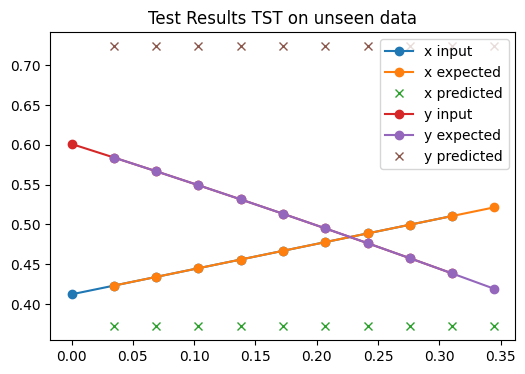

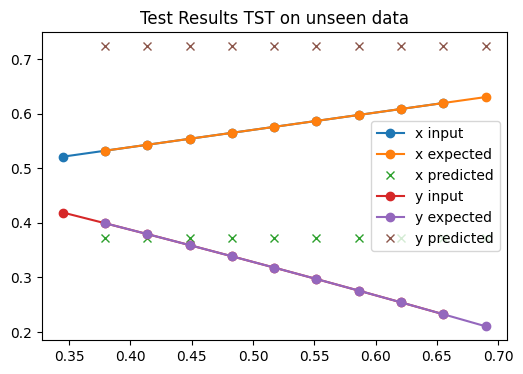

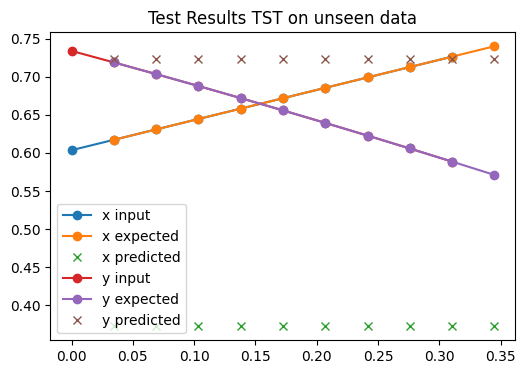

In [ ]:
# display test results
import matplotlib.pyplot as plt
for i in [0, 10, 19]:
    
    plt.figure(i, figsize=(6, 4))
    plt.plot(X_test_times[i,:], X_test[i,:,0], "-o", label='x input')
    plt.plot(y_test_times[i,:], y_test[i,:,0], "-o", label='x expected')
    plt.plot(y_test_times[i,:], outputs[i,:,0] , "x", label='x predicted')
    
    plt.plot(X_test_times[i,:], X_test[i,:,1], "-o", label='y input')
    plt.plot(y_test_times[i,:],y_test[i,:,1], "-o", label='y expected')
    plt.plot(y_test_times[i,:],outputs[i,:,1] , "x", label='y predicted')
    plt.title(f"Test Results TST on unseen data")
    plt.legend()

In [ ]:
from torchinfo import summary

print(summary(model, input_data=(X_test, X_test, sequence_size)))

Layer (type:depth-idx)                             Output Shape              Param #
TransformerModel                                   [95, 10, 2]               --
├─Linear: 1-1                                      [95, 10, 2]               6
├─Linear: 1-2                                      [95, 10, 2]               (recursive)
├─Transformer: 1-3                                 [95, 10, 2]               --
│    └─TransformerEncoder: 2-1                     [95, 10, 2]               --
│    │    └─ModuleList: 3-1                        --                        10,274
│    │    └─LayerNorm: 3-2                         [95, 10, 2]               4
│    └─TransformerDecoder: 2-2                     [95, 10, 2]               --
│    │    └─ModuleList: 3-3                        --                        10,302
│    │    └─LayerNorm: 3-4                         [95, 10, 2]               4
├─Linear: 1-4                                      [95, 10, 2]               6
Total params: 20,596
T